# **Workshop Overview: Reinforcement Learning with Actor-Critic, PPO, and SAC in Discrete CartPole**

This workshop explores **three key reinforcement learning algorithms**—**Actor-Critic (AC), Proximal Policy Optimization (PPO), and Soft Actor-Critic (SAC)**—and applies them to the **discrete CartPole environment**. The notebook provides a step-by-step guide to implementing these algorithms, training agents, and evaluating their performance, making it a valuable resource for understanding policy-based reinforcement learning methods.

## **Objectives of the Workshop**
- Gain a solid understanding of **policy-based reinforcement learning** methods.
- Implement **AC, PPO, and SAC** algorithms from scratch using PyTorch.
- Train and compare these methods in the **CartPole-v1 environment** (discrete action space).
- Analyze their **performance, stability, and sample efficiency**.
- Provide insights into **advantages, challenges, and potential improvements** for each algorithm.

## **Notebook Structure**
### **1. Introduction and Setup**
The notebook starts with an overview of reinforcement learning concepts, followed by setting up required libraries and configuring the OpenAI Gym **CartPole** environment.

### **2. Implementing Actor-Critic (AC)**
- Introduces the **Actor-Critic (AC) algorithm**, which combines value-based and policy-based learning.
- Defines the **actor (policy network)** and **critic (value network)** in PyTorch.
- Implements the **training loop**, updating both networks using the policy gradient and value loss.

### **3. Implementing Proximal Policy Optimization (PPO)**
- Introduces **PPO**, an improvement over vanilla policy gradient methods.
- Implements **clipped surrogate objective**, trust-region constraints, and **entropy regularization**.
- Compares PPO with AC in terms of **stability and sample efficiency**.

### **4. Implementing Soft Actor-Critic (SAC)**
- Adapts the **SAC algorithm** to the **discrete CartPole environment**.
- Implements  entropy maximization, and **stochastic policies** for better exploration.
- Compares SAC with PPO and AC, analyzing its **advantages in discrete action spaces**.

### **5. Training and Evaluation**
- Trains **all three algorithms** on **CartPole-v1** and logs training statistics.
- Evaluates **reward curves, policy stability, and convergence rates**.
- Plots and compares **learning performance across different episodes**.


## **Key Takeaways**
- **AC** provides a simple yet effective baseline but struggles with stability.
- **PPO** improves training stability and **handles policy updates better** than AC.
- **SAC**, although originally designed for continuous actions, can be adapted for **discrete tasks** and provides **better exploration**.

This notebook serves as a **comprehensive guide to modern policy-based reinforcement learning methods** and their application in discrete action spaces. Participants will gain hands-on experience with **training and evaluating deep RL agents**, setting the stage for further exploration in reinforcement learning research.


# **Import Required Libraries**

In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.distributions import Categorical
from torch.distributions.categorical import Categorical
import pandas as pd
import numpy as np

from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym

import copy
import os
import shutil

import logging
import matplotlib
import matplotlib.pyplot as plt

import imageio
from IPython.display import HTML
from base64 import b64encode

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

logging.getLogger().setLevel(logging.ERROR)



# **Visualization and Logging Functions**

This section configures logging, sets up real-time reward plotting, and provides a function to display recorded gameplay videos for monitoring the training process.

In [2]:
logging.getLogger().setLevel(logging.ERROR)


# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

############################################################################

def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


#############################################################################
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

#############################################################################
def plot_graph(reward_history, avg_reward):


  df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
  palette = plt.get_cmap('Set1')

  plt.plot(df['x'], df['Reward'], marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')
  plt.plot(df['x'], df['Average'], marker='', color='tomato', linewidth=1, alpha=0.9, label='Average')

  # plt.legend(loc='upper left')
  plt.title("CartPole", fontsize=14)
  plt.xlabel("episode", fontsize=12)
  plt.ylabel("score", fontsize=12)

  plt.savefig('score.png')



# **ACTOR-CRITIC Algorithm**

Random actions in the ***CartPole-v1*** envitonment

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

env.reset()
for _ in range(100):
    frames.append(env.render())
    action = env.action_space.sample() # select a random action
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.close()
imageio.mimsave('./CartPole.mp4', frames, fps=25)
show_video('./CartPole.mp4')


# **Actor-Critic structure**

In [4]:
class Network(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=256, dropout = 0.1):
        super(Network, self).__init__()

        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)
        

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
        self.dropout = nn.Dropout(dropout)


    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))

        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

## **Actor_critic agent**

In [5]:
class Actor_Critic:
    def __init__(self, network, optim, learning_rate=0.008, discount=0.99, mode=0):

        self.actor_critic = network
        self.ac_optimizer = optim

        self.values, self.log_probs =[],[]

        self.discount = discount
        self.mode = mode  # mode= 0 -> reinforce, mode= 1 -> advantage, mode=2 -> GAE


    def action(self, state):
        # policy_dist = self.actor.forward(state)
        value, policy_dist = self.actor_critic.forward(state)
        dist = policy_dist.detach().numpy()
        probs = np.squeeze(dist)
        action = np.random.choice(2, p = probs)
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        # value = self.critic.forward(state)
        value = value.detach().numpy()[0,0]

        self.values.append(value)
        self.log_probs.append(log_prob)

        return action
    def update(self, rewards, last_state):
        values = torch.FloatTensor(self.values)
        returns = self.returns(rewards)
        
        match self.mode:
          case 0:
            advantages = self.calculate_Qval(rewards, last_state)
          case 1:
            advantages = self.calculate_advantage(rewards, last_state)
          case 2:
            advantages = self.calculate_GAE(rewards, last_state)



        advantages = torch.FloatTensor(advantages)
        log_probs = torch.stack(self.log_probs)
        actor_loss = (-log_probs * advantages).mean()
        critic_loss = 0.5 * returns.pow(2).mean()
        ac_loss = actor_loss + critic_loss
        self.ac_optimizer.zero_grad()
        ac_loss.backward()
        self.ac_optimizer.step()
        self.values, self.log_probs =[],[]


    def returns(self, rewards):
      returns = []
      R = 0
      for r in reversed(rewards):
        R = r +  R * self.discount
        returns.insert(0, R)

      return torch.tensor(returns)
    
    def calculate_Qval(self, rewards, last_state):
      Qval, policy_dist = self.actor_critic.forward(last_state)
      Qval = Qval.detach().numpy()[0,0]
      
      Qvals = np.zeros_like(self.values)
      for t in reversed(range(len(rewards))):
          if (t < len(rewards) - 1):
            Qval = rewards[t] + self.discount * Qval
          Qvals[t] = Qval
          
      return Qvals 
    

    def calculate_advantage (self, rewards, last_state):
      Qval, policy_dist = self.actor_critic.forward(last_state)
      Qval = Qval.detach().numpy()[0,0]
      
      Qvals = np.zeros_like(self.values)
      for t in reversed(range(len(rewards))):
          if (t < len(rewards) - 1):
            Qval = rewards[t] + self.discount * Qval
          Qvals[t] = Qval

      advantage = Qvals - self.values
      return advantage

    def calculate_GAE(self, rewards, last_state, trace_decay = 0.98):
      advantages = self.calculate_advantage(rewards, last_state)
      GAE= []
      t= True
      for adv in reversed(advantages):
        if t:
          gae = adv
          t= False
        else: 
          gae =  adv + trace_decay* gae

        GAE.insert(0,gae)

      return GAE


In [6]:
env = gym.make("CartPole-v1")
max_episodes = 2000
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
learning_rate = 5e-4

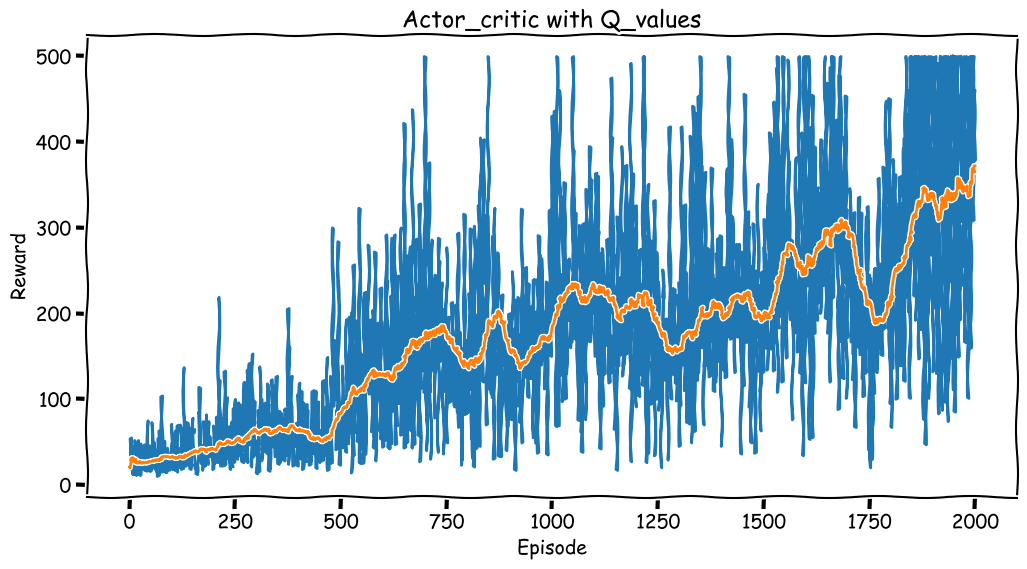

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [7]:
actor_critic = Network(state_dim, action_dim)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
agent = Actor_Critic(actor_critic, ac_optimizer, mode =0)
scheduler = StepLR(ac_optimizer, step_size=20, gamma=0.99)
all_rewards=[]

for episode in range(max_episodes):
    rewards = []
    state,_ = env.reset()
    done,terminate = False,False
    step = 0
    # while (not done) and (not terminate):
    while True:
    # for steps in range(num_steps):
        action = agent.action(state)
        new_state, reward, done, terminate,_ = env.step(action)
        rewards.append(reward)
        state = new_state
        step +=1
        if done or terminate:
            break
    agent.update(rewards, state)
    scheduler.step()
    all_rewards.append(np.sum(rewards))
    plot_rewards(all_rewards)
plot_rewards(all_rewards, show_result='Actor_critic with Q_values')


In [8]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
while True:
    frames.append(env.render())
    action  = agent.action(state)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./QAC.mp4', frames, fps=25)
show_video('./QAC.mp4')

Total Reward: 500.0


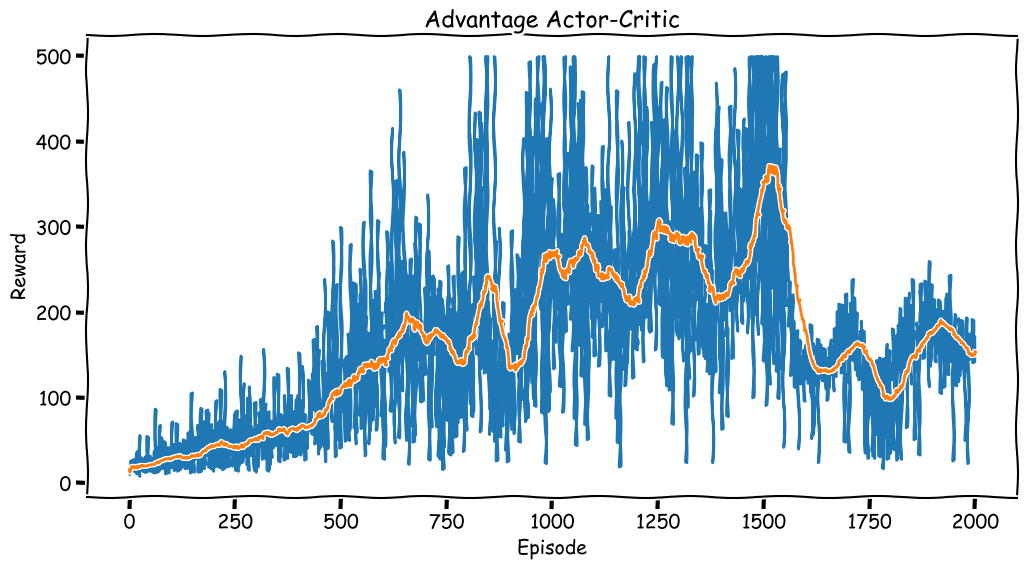

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [9]:
actor_critic = Network(state_dim, action_dim)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
agent_advangate = Actor_Critic(actor_critic, ac_optimizer, mode =1)
scheduler = StepLR(ac_optimizer, step_size=50, gamma=0.99)
all_rewards=[]
n=50

for episode in range(max_episodes):
    rewards = []
    state,_ = env.reset()
    done,terminate = False,False
    step = 0
    # while (not done) and (not terminate):
    while True:
    # for steps in range(num_steps):
        action = agent_advangate.action(state)
        new_state, reward, done, terminate,_ = env.step(action)
        rewards.append(reward)
        state = new_state
        step +=1
        if done or terminate:
            break
    agent_advangate.update(rewards, state)
    scheduler.step()
    all_rewards.append(np.sum(rewards))
    plot_rewards(all_rewards)


    max_value = max(all_rewards)
    if len(all_rewards) >= n and all_rewards[-n:] == [max_value] * n:
        break
plot_rewards(all_rewards, show_result='Advantage Actor-Critic')

In [10]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
while True:
    frames.append(env.render())
    action  = agent_advangate.action(state)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_reinforce.mp4', frames, fps=25)
show_video('./eval_reinforce.mp4')

Total Reward: 173.0


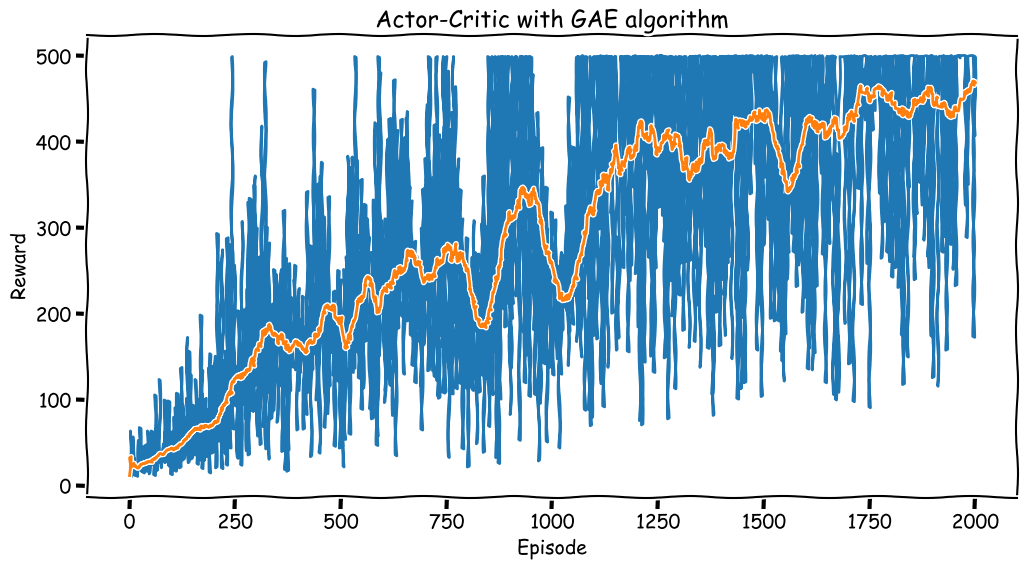

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
actor_critic = Network(state_dim, action_dim)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
agent_GAE = Actor_Critic(actor_critic, ac_optimizer, mode =2)
scheduler = StepLR(ac_optimizer, step_size=20, gamma=0.99)
all_rewards=[]
n=50

for episode in range(max_episodes):
    rewards = []
    state,_ = env.reset()
    done,terminate = False,False
    step = 0
    # while (not done) and (not terminate):
    while True:
    # for steps in range(num_steps):
        action = agent_GAE.action(state)
        new_state, reward, done, terminate,_ = env.step(action)
        rewards.append(reward)
        state = new_state
        step +=1
        if done or terminate:
            break
    agent_GAE.update(rewards, state)
    scheduler.step()
    all_rewards.append(np.sum(rewards))
    plot_rewards(all_rewards)


    max_value = max(all_rewards)
    if len(all_rewards) >= n and all_rewards[-n:] == [max_value] * n:
        break

plot_rewards(all_rewards, show_result='Actor-Critic with GAE algorithm')

In [12]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
while True:
    frames.append(env.render())
    action  = agent_GAE.action(state)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_reinforce.mp4', frames, fps=25)
show_video('./eval_reinforce.mp4')

Total Reward: 500.0


# **PPO Algorithm**

## **Experience Memory for PPO Training**


In [13]:
class Memory:   # collected from old policy
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []

    def clear_memory(self):
        del self.states[:]
        del self.actions[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.logprobs[:]

## **Configuration Settings for PPO Training**


In [14]:
class Config:
    # Environment settings
    ENV_NAME = "CartPole-v1"
    SEED = 111
    MAX_EPISODES = 400
    MAX_TIMESTEPS = 500

    # PPO Hyperparameters
    K_EPOCHS = 5
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 0.002
    BETAS = (0.9, 0.99)

    PLOT_INTERVAL = 10

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## **Actor-Critic Network for PPO**
This class implements an Actor-Critic neural network for PPO. The actor network outputs a probability distribution over actions using a softmax layer, while the critic network estimates the state value. The act method selects an action (either deterministically or stochastically) and stores it in memory. The evaluate method returns action log probabilities, state values, and entropy for policy optimization.

In [15]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def act(self, state, memory, deterministic):
        action_probs = self.actor(state)
        if deterministic:
          action = torch.argmax(action_probs)
        else:
          dist = Categorical(action_probs)
          action = dist.sample()
          action_logprob = dist.log_prob(action)

          memory.states.append(state)
          memory.actions.append(action)
          memory.logprobs.append(action_logprob)

        return action.item()

    def evaluate(self, state, action):
        state_value = self.critic(state)
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return action_logprobs, torch.squeeze(state_value), dist_entropy


## **PPO (Proximal Policy Optimization) Agent**


In [16]:
class PPO:
    def __init__(self, state_dim, action_dim, config):
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.K_epochs = config.K_EPOCHS
        self.device = config.DEVICE

        self.policy = ActorCritic(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=config.LEARNING_RATE, betas=config.BETAS)

        self.old_policy = ActorCritic(state_dim, action_dim).to(self.device)
        self.old_policy.load_state_dict(self.policy.state_dict())

        self.MSE_loss = nn.MSELoss()

    def select_action(self, state, memory, deterministic):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        return self.old_policy.act(state, memory, deterministic)

    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards).to(self.device)
        # rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        old_states = torch.squeeze(torch.stack(memory.states)).to(self.device).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions)).to(self.device).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).to(self.device).detach()

        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2)

            critic_loss = 0.5 * self.MSE_loss(rewards, state_values) - 0.01 * dist_entropy
            loss = actor_loss + critic_loss

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.old_policy.load_state_dict(self.policy.state_dict())


## **Environment and Agent Initialization**


In [17]:
config = Config()

print("Random Seed: {}".format(config.SEED))
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)


env_name = config.ENV_NAME
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print('Environment: {}\nState Size: {}\nAction Size: {}\n'.format(env_name, state_dim, action_dim))

memory = Memory()
agent = PPO(state_dim, action_dim, config)


Random Seed: 111
Environment: CartPole-v1
State Size: 4
Action Size: 2



## **PPO Training Loop**


Episode 1 	 Length: 21 	 Reward: 21.00
Episode 2 	 Length: 38 	 Reward: 38.00
Episode 3 	 Length: 13 	 Reward: 13.00
Episode 4 	 Length: 24 	 Reward: 24.00
Episode 5 	 Length: 43 	 Reward: 43.00
Episode 6 	 Length: 36 	 Reward: 36.00
Episode 7 	 Length: 37 	 Reward: 37.00
Episode 8 	 Length: 20 	 Reward: 20.00
Episode 9 	 Length: 25 	 Reward: 25.00
Episode 10 	 Length: 17 	 Reward: 17.00
Episode 11 	 Length: 22 	 Reward: 22.00
Episode 12 	 Length: 23 	 Reward: 23.00
Episode 13 	 Length: 30 	 Reward: 30.00
Episode 14 	 Length: 21 	 Reward: 21.00
Episode 15 	 Length: 16 	 Reward: 16.00
Episode 16 	 Length: 46 	 Reward: 46.00
Episode 17 	 Length: 33 	 Reward: 33.00
Episode 18 	 Length: 30 	 Reward: 30.00
Episode 19 	 Length: 35 	 Reward: 35.00
Episode 20 	 Length: 28 	 Reward: 28.00
Episode 21 	 Length: 37 	 Reward: 37.00
Episode 22 	 Length: 28 	 Reward: 28.00
Episode 23 	 Length: 19 	 Reward: 19.00
Episode 24 	 Length: 21 	 Reward: 21.00
Episode 25 	 Length: 18 	 Reward: 18.00
Episode 2

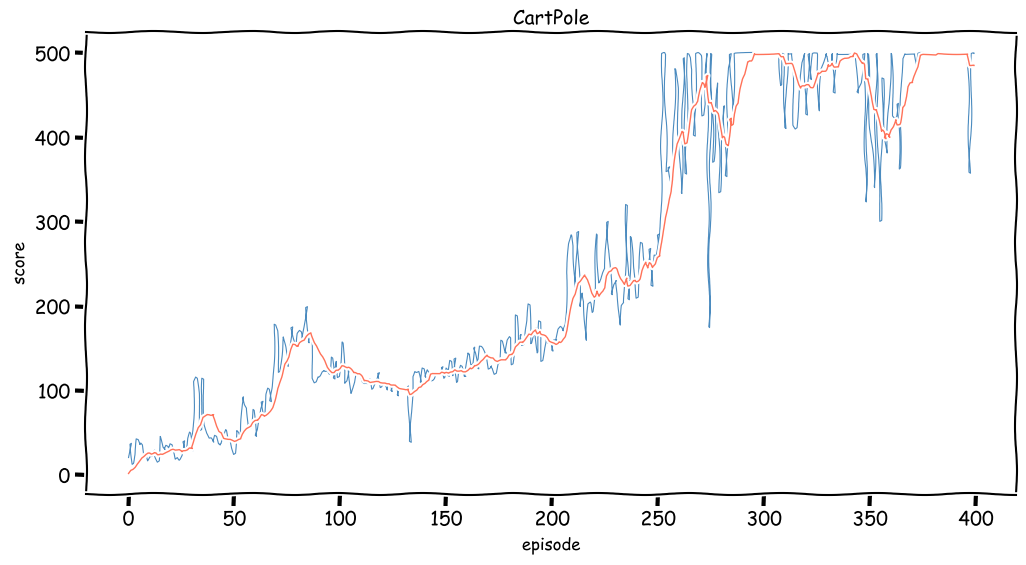

In [18]:
# Initialize variables
episode = 0
step = 0
rewards_history = []
avg_reward = []

# Training loop
for i_episode in range(1, config.MAX_EPISODES + 1):
    state, _ = env.reset()
    done = False  # Reset done flag
    episode += 1
    running_reward = 0
    start_step = step

    # Run an episode
    while not done:
        action = agent.select_action(state, memory, deterministic=False)
        state, reward, done, truncated, _ = env.step(action)

        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        done = (done or truncated)

        running_reward += reward
        step += 1  # Increment step counter

    # Episode completed
    episode_length = step - start_step
    rewards_history.append(running_reward)
    avg_reward.append(sum(rewards_history[-10:])/10.0)

    print(f"Episode {i_episode} \t Length: {episode_length} \t Reward: {running_reward:.2f}")

    # Update PPO at the end of the episode
    agent.update(memory)
    memory.clear_memory()  # Clear memory after PPO update

    # Plot at intervals
    if i_episode % config.PLOT_INTERVAL == 0:
        plot_graph(rewards_history, avg_reward)  



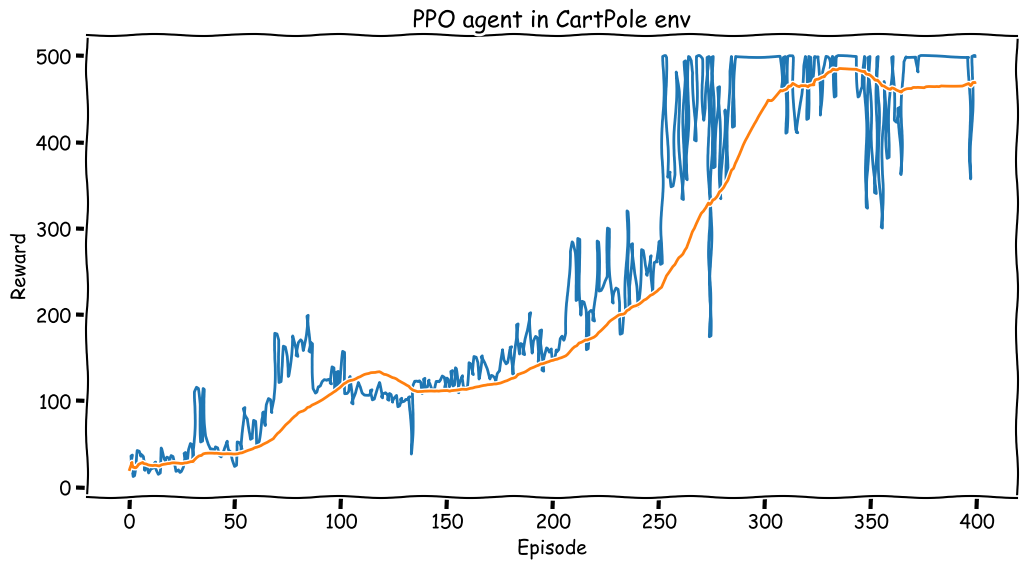

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [19]:
plot_rewards(rewards_history, show_result="PPO agent in CartPole env")

## **Evaluation of Agent on CartPole-v1 and Video Generation**


In [20]:
# Create environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

while not done:
    # Take deterministic actions at test time
    action = agent.select_action(state, memory, deterministic=True)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = (terminated or truncated)

    # Store frame for video
    frames.append(env.render())

    state = next_state
    total_reward += reward


env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

Total Reward: 500.0


# **SAC Algorithm**

## **Neural Network Architectures for SAC-Discrete**

This cell defines two key neural networks used in the Soft Actor-Critic for Discrete Actions (SAC-Discrete) algorithm:

- `Q_Net` (Critic Network)
- `Policy_Net` (Actor Network)

Both networks share a three-layer feedforward architecture with ReLU activation function.

In [21]:
class Q_Net(nn.Module):
    def __init__(self, state_dim, action_dim, hid_shape):
        super(Q_Net, self).__init__()
    
        self.fc1_q1 = nn.Linear(state_dim, hid_shape[0])
        self.fc2_q1 = nn.Linear(hid_shape[0], hid_shape[1])
        self.fc3_q1 = nn.Linear(hid_shape[1], action_dim)

        self.activation = nn.ReLU()
        self.output_activation = nn.Identity()

    def forward(self, state):
        q1 = self.activation(self.fc1_q1(state))
        q1 = self.activation(self.fc2_q1(q1))
        q1 = self.output_activation(self.fc3_q1(q1))
        return q1

class Policy_Net(nn.Module):
    def __init__(self, state_dim, action_dim, hid_shape):
        super(Policy_Net, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hid_shape[0])
        self.fc2 = nn.Linear(hid_shape[0], hid_shape[1])
        self.fc3 = nn.Linear(hid_shape[1], action_dim)
        
        self.activation = nn.ReLU()
        self.output_activation = nn.Identity()

    def forward(self, state):
        logits = self.activation(self.fc1(state))
        logits = self.activation(self.fc2(logits))
        logits = self.output_activation(self.fc3(logits))
        
        probs = F.softmax(logits, dim=1)
        return probs

## **Replay Buffer for Experience Replay**
The `ReplayBuffer` class is a critical component of SAC, as it enables experience replay, which stabilizes training by decorrelating transitions.

In [22]:
class ReplayBuffer(object):
	def __init__(self, state_dim, device, max_size=int(1e6)):
		self.max_size = max_size
		self.device = device
		self.ptr = 0
		self.size = 0

		self.state = torch.zeros((max_size, state_dim),dtype=torch.float,device=self.device)
		self.action = torch.zeros((max_size, 1),dtype=torch.long,device=self.device)
		self.reward = torch.zeros((max_size, 1),dtype=torch.float,device=self.device)
		self.next_state = torch.zeros((max_size, state_dim),dtype=torch.float,device=self.device)
		self.dones = torch.zeros((max_size, 1),dtype=torch.bool,device=self.device)

	def add(self, state, action, reward, next_state, done):
		self.state[self.ptr] = torch.from_numpy(state).to(self.device)
		self.action[self.ptr] = action
		self.reward[self.ptr] = reward
		self.next_state[self.ptr] = torch.from_numpy(next_state).to(self.device)
		self.dones[self.ptr] = done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self, batch_size):
		idx = torch.randint(0, self.size, device=self.device, size=(batch_size,))
		return self.state[idx], self.action[idx], self.reward[idx], self.next_state[idx], self.dones[idx]



## **implementation of SAC agent**

The `SACD_agent` class implements the Soft Actor-Critic (SAC) algorithm for discrete action spaces.


In [23]:
class SACD_agent:
    def __init__(self, config):
        self.device = torch.device(config.device)
        self.gamma = config.gamma
        self.tau = 0.005
        self.lr = config.lr
        self.batch_size = config.batch_size
        self.alpha = config.alpha
        self.state_dim = config.state_dim
        self.action_dim = config.action_dim
        self.hidden_shape = config.hidden_shape
        self.H_mean = 0
        self.q_loss = 0.0

        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.state_dim, self.device, max_size=int(1e6))

        # Initialize networks
        self.actor = Policy_Net(self.state_dim, self.action_dim, self.hidden_shape).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)

        self.q_critic = Q_Net(self.state_dim, self.action_dim, self.hidden_shape).to(self.device)
        self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=self.lr)
        self.q_critic_target = copy.deepcopy(self.q_critic)
        for p in self.q_critic_target.parameters():
            p.requires_grad = False


    def select_action(self, state, deterministic=False):
        with torch.no_grad():
            state = torch.FloatTensor(state[np.newaxis, :]).to(self.device)  # Convert to tensor
            probs = self.actor(state)
            if deterministic:
                action = probs.argmax(-1).item()
            else:
                action = Categorical(probs).sample().item()
            return action

    def train(self):
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        # Train Critic
        with torch.no_grad():
            next_probs = self.actor(next_state)  # [batch_size, action_dim]
            next_log_probs = torch.log(next_probs + 1e-8)

            next_q_all = self.q_critic_target(next_state)
            v_next = torch.sum(next_probs * (next_q_all - self.alpha * next_log_probs), dim=1, keepdim=True)
            target_Q = reward + (~done) * self.gamma * v_next

        q_all = self.q_critic(state)
        q_value = q_all.gather(1, action)
        q_loss = F.mse_loss(q_value, target_Q)
        self.q_loss = q_loss.item()

        self.q_critic_optimizer.zero_grad()
        q_loss.backward()
        self.q_critic_optimizer.step()

        # Train Actor
        probs = self.actor(state)
        log_probs = torch.log(probs + 1e-8)
        with torch.no_grad():
            q_all = self.q_critic(state)
        
        actor_loss = torch.sum(probs * (self.alpha * log_probs - q_all), dim=1).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update Target Network
        for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return q_loss.item()

    def save(self, timestep, env_name):
        torch.save(self.actor.state_dict(), f"./model/sacd_actor_{timestep}_{env_name}.pth")
        torch.save(self.q_critic.state_dict(), f"./model/sacd_critic_{timestep}_{env_name}.pth")

    def load(self, timestep, env_name):
        self.actor.load_state_dict(torch.load(f"./model/sacd_actor_{timestep}_{env_name}.pth", map_location=self.device))
        self.q_critic.load_state_dict(torch.load(f"./model/sacd_critic_{timestep}_{env_name}.pth", map_location=self.device))


In [24]:
def evaluate_policy(env, agent, turns = 3):
	total_scores = 0
	for _ in range(turns):
		state, _ = env.reset()
		done = False
		while not done:
			# Take deterministic actions at test time
			action = agent.select_action(state, deterministic=True)
			next_state, reward, terminated, truncated, _ = env.step(action)
			done = (terminated or truncated)

			total_scores += reward
			state = next_state
	return int(total_scores/turns)

In [25]:
class Config:
    # General settings
    device = 'cuda'  # Running device: 'cuda' or 'cpu'
    EnvIdex = 0 # 0: CartPole-v1, 1: LunarLander-v3
    write = True  # Use SummaryWriter for logging
    render = False # Render environment
    Loadmodel = False  # Load pretrained model

    # Training settings
    seed = 0  # Random seed
    Max_train_steps = 200  # Max training steps
    save_interval = 25  # Model saving interval
    eval_interval = 1  # Evaluation interval
    update_every = 5  # Training frequency

    # SACD hyperparameters
    gamma = 0.99  # Discount factor
    hidden_shape = [256, 256]  # Hidden layer shape
    lr = 5e-4  # Learning rate
    batch_size = 256  # Batch size
    alpha = 1 # Initial alpha value


In [26]:
#Load hyperparameters
opt = Config()

# Create Environment
EnvName = ['CartPole-v1', 'LunarLander-v3']
env = gym.make(EnvName[opt.EnvIdex], render_mode="human" if opt.render else None)
eval_env = gym.make(EnvName[opt.EnvIdex])
opt.state_dim = env.observation_space.shape[0]
opt.action_dim = env.action_space.n
opt.max_e_steps = env._max_episode_steps

# Set seeds
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Running SACD on {EnvName[opt.EnvIdex]} with seed {opt.seed}")

# Initialize logging
if opt.write:
    log_dir = f"runs/SACD_{EnvName[opt.EnvIdex]}_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    writer = SummaryWriter(log_dir=log_dir)

# Initialize agent
if not os.path.exists('model'):
    os.mkdir('model')

agent = SACD_agent(opt)

if opt.Loadmodel:
    agent.load(opt.ModelIdex, EnvName[opt.EnvIdex])

Running SACD on CartPole-v1 with seed 0


## **Training and Evaluation Part**

In [27]:
# Training loop with episodes
total_episodes = 0
EPISODES_PER_RUN = 200

reward_history = []
step_history = []

while total_episodes < opt.Max_train_steps:

    total_episodes += 1  

    state, info = env.reset(seed=opt.seed)
    done = False
    episode_reward = 0
    episode_steps = 0  # Track steps per episode

    while not done:
        action = agent.select_action(state, deterministic=False)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1  # Count steps in this episode

        if opt.EnvIdex == 1 and reward <= -100:  
            reward = -10  # Reward adjustment for LunarLander

        agent.replay_buffer.add(state, action, reward, next_state, terminated)
        state = next_state

    # Train the agent at the end of each episode
    for _ in range(EPISODES_PER_RUN):  # Train for as many steps as in the episode
            agent.train()

    '''Record & Log'''
    if total_episodes % opt.eval_interval == 0:
        score = evaluate_policy(eval_env, agent, turns=3)
        step_history.append(total_episodes)
        reward_history.append(score)

        if opt.write:
            writer.add_scalar('ep_r', score, global_step=total_episodes)
            writer.add_scalar('alpha', agent.alpha, global_step=total_episodes)
            writer.add_scalar('H_mean', agent.H_mean, global_step=total_episodes)
        
        print(f'EnvName: {EnvName[opt.EnvIdex]}, Seed: {opt.seed}, Episode: {total_episodes}, Score: {int(score)}')

    # Save model
    if total_episodes % opt.save_interval == 0:
        agent.save(total_episodes, EnvName[opt.EnvIdex])


env.close()
eval_env.close()


EnvName: CartPole-v1, Seed: 0, Episode: 1, Score: 9
EnvName: CartPole-v1, Seed: 0, Episode: 2, Score: 9
EnvName: CartPole-v1, Seed: 0, Episode: 3, Score: 17
EnvName: CartPole-v1, Seed: 0, Episode: 4, Score: 192
EnvName: CartPole-v1, Seed: 0, Episode: 5, Score: 164
EnvName: CartPole-v1, Seed: 0, Episode: 6, Score: 172
EnvName: CartPole-v1, Seed: 0, Episode: 7, Score: 208
EnvName: CartPole-v1, Seed: 0, Episode: 8, Score: 184
EnvName: CartPole-v1, Seed: 0, Episode: 9, Score: 171
EnvName: CartPole-v1, Seed: 0, Episode: 10, Score: 200
EnvName: CartPole-v1, Seed: 0, Episode: 11, Score: 233
EnvName: CartPole-v1, Seed: 0, Episode: 12, Score: 253
EnvName: CartPole-v1, Seed: 0, Episode: 13, Score: 319
EnvName: CartPole-v1, Seed: 0, Episode: 14, Score: 221
EnvName: CartPole-v1, Seed: 0, Episode: 15, Score: 281
EnvName: CartPole-v1, Seed: 0, Episode: 16, Score: 340
EnvName: CartPole-v1, Seed: 0, Episode: 17, Score: 212
EnvName: CartPole-v1, Seed: 0, Episode: 18, Score: 225
EnvName: CartPole-v1, Se

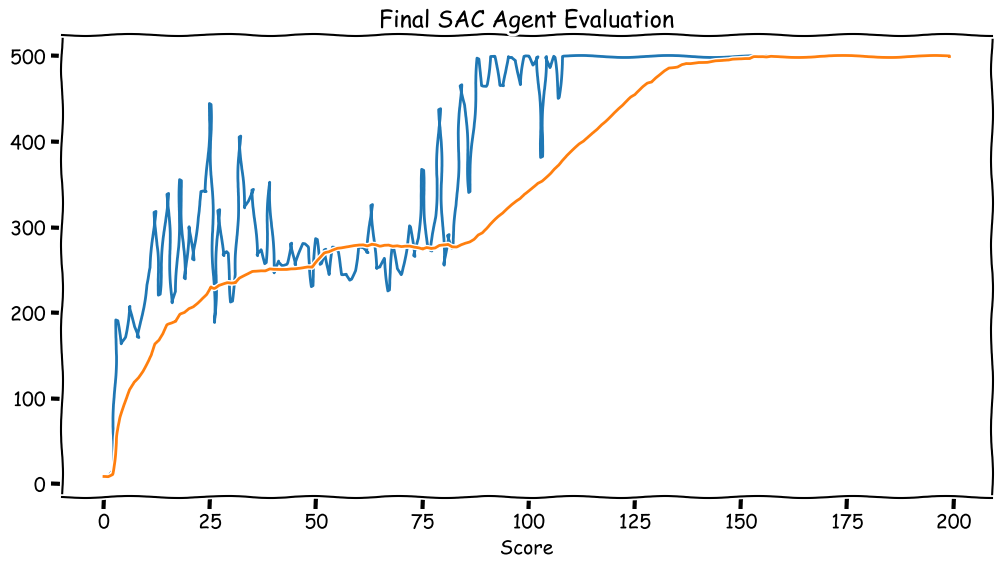

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [28]:
plot_rewards(reward_history, show_result="Final SAC Agent Evaluation", bove="Episode", dn="Score")
plt.ioff()
plt.show()

In [29]:
# Create environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

while not done:
    # Take deterministic actions at test time
    action = agent.select_action(state, deterministic=True)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = (terminated or truncated)

    # Store frame for video
    frames.append(env.render())

    state = next_state
    total_reward += reward


env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

Total Reward: 500.0
